In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from keras.layers import Embedding, Dense, Permute, RepeatVector
from keras.layers import Lambda, Conv1D, Dropout, Activation, Multiply, Flatten
from keras.models import Sequential, Input, Model
from keras.models import K

from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
sns.set_context("paper")
sns.set_style("ticks")

In [3]:
vocab_size=10
emb_size=3
num_filters=6
kernel_size=3
maxlen=5

## Helper functions

In [4]:
class Vocab(object):
    def __init__(
        self,
        pre_tokens=("__PAD__", "__BOS__", "__EOS__", ),
        UNK="__UNK__",
        preprocess=lambda x: x
    ):
        self.UNK = UNK
        self.word2idx = {}
        self.idx2word = []
        self.offset_tokens = set((self.UNK, ) + pre_tokens)
        self.preprocess = preprocess
        for token in pre_tokens + (self.UNK, ):
            self.add_token(token)

    def add_token(self, token):
        if token not in self.offset_tokens:
            token = self.preprocess(token)
        if token not in self.word2idx:
            self.word2idx[token] = len(self.word2idx)
            self.idx2word.append(token)

    def get_word2idx(self, token):
        if token not in self.offset_tokens:
            token = self.preprocess(token)
        return self.word2idx.get(token, self.UNK)

    def process_seq(self, seq):
        return [self.get_word2idx(token) for token in seq]

    
    
def generate_vocab(documents):
    """Generate vocab from list of documents
    
    Args:
    -----
        documents: list of document where each document is a list of words
    
    Returns:
    --------
        vocab: Vocab object
    """
    vocab = Vocab()
    for document in (documents):
        for word in document:
            vocab.add_token(word)
    return vocab

def create_sequences(documents, labels, vocab, maxlen):
    """Create sequences for keras models
    
    Args:
    -----
        documents: list of document where each document is a list of words
        labels: list of labels per document. Only binary classification is supported, i.e. 0, 1
        
    Returns:
    --------
        
    """
    X = []
    y = np.asarray(labels)
    for document in (documents):
        seq = []
        for word in document:
            seq.append(word)
        X.append(vocab.process_seq(seq))
    X_padded = sequence.pad_sequences(X, maxlen=maxlen)
    return X_padded, y
    

## Basic model which takes sequence and outputs sequence

In [5]:
def get_base_model():
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(vocab_size,
                        emb_size,
                        input_length=maxlen))
    model.add(Dropout(0.2))
    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(
        Conv1D(
            num_filters,
            kernel_size,
            padding='same',
            activation='relu',
            strides=1
        )
    )
    return model
    
def get_attention_model():
    attention = Sequential()
    attention.add(Dense(num_filters, input_shape=(maxlen, num_filters), activation="tanh"))
    attention.add(Dense(1))
    attention.add(Flatten())
    attention.add(Activation("softmax"))
    return attention

def get_output(base_model, attention, inputs):
    activations = base_model(inputs)
    permited_activations = Permute((2,1))(activations)
    aligned_attention = RepeatVector(num_filters)(attention(activations))
    final_activation = Multiply()([
        permited_activations,
        aligned_attention
    ])
    final_score = Flatten()(final_activation)
    output = Lambda(lambda x: K.sum(x,-1, keepdims=True))(final_score)
    output = Activation("sigmoid")(output)
    return output

def get_model():
    inputs = Input((maxlen,))
    base_model = get_base_model()
    attention = get_attention_model()
    output = get_output(base_model, attention, inputs)
    model = Model(inputs=inputs, outputs=output)
    return model

In [6]:
model = get_model()

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5, 6)         90          input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 5)            49          sequential_1[1][0]               
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 6, 5)         0           sequential_1[1][0]               
__________________________________________________________________________________________________
repeat_vec

In [8]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [9]:
data_size=100
X = np.random.randint(vocab_size, size=(data_size, maxlen))
y = np.random.randint(2, size=(data_size,1))
X.shape, y.shape

((100, 5), (100, 1))

In [10]:
model.fit(X, y)

Epoch 1/1
100/100 [==============================] - 2s 24ms/step - loss: 0.6960 - acc: 0.4600


## Fit model on data

In [11]:
documents = [
    ["The", "world", "is", "on", "fire"],
    ["The", "earth", "is", "on", "fire"],
    ["The", "country", "is", "on", "ice"],
    ["The", "book", "is", "on", "fire"],
    ["The", "cat", "is", "on", "trampoline"],
]

labels = [0,0,1,0,1]
vocab = generate_vocab(documents)

In [12]:
X, y = create_sequences(documents, labels, vocab, maxlen)

In [13]:
X.shape, y.shape

((5, 5), (5,))

In [14]:
model.fit(X, y)

Epoch 1/1
5/5 [==============================] - 0s 3ms/step - loss: 0.6967 - acc: 0.4000


In [15]:
model.layers

In [16]:
model.layers[1].get_output_at(0), model.layers[2].get_output_at(0)

(<tf.Tensor 'conv1d_1/Relu:0' shape=(?, 5, 6) dtype=float32>,
 <tf.Tensor 'activation_1/Softmax:0' shape=(?, ?) dtype=float32>)

In [17]:
model.layers[1].get_input_at(0)

<tf.Tensor 'embedding_1_input:0' shape=(?, 5) dtype=float32>

In [18]:
conv_activation = K.function(
    [
        model.layers[1].get_input_at(0),
        K.learning_phase()
    ],
    [model.layers[1].get_output_at(0)]
)

In [19]:
conv_activation

In [20]:
conv_activation([
    [X[0]],
    0.
])

[array([[[ 0.        ,  0.        ,  0.01670015,  0.        ,  0.01758255,
           0.        ],
         [ 0.01330368,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.02499684,  0.        ,  0.        ,  0.        ,
           0.03441959],
         [ 0.00910494,  0.        ,  0.00106554,  0.        ,  0.02439762,
           0.        ],
         [ 0.        ,  0.01371591,  0.        ,  0.        ,  0.        ,
           0.        ]]], dtype=float32)]

In [21]:
model.layers[2].get_input_at(0)

<tf.Tensor 'dense_1_input:0' shape=(?, 5, 6) dtype=float32>

In [22]:
attention_activation = K.function(
    [
        model.layers[2].get_input_at(0),
        K.learning_phase()
    ],
    [model.layers[2].get_output_at(0)]
)

In [23]:
attention_activation([
    conv_activation([[X[0]],0.])[0],
    0.
])

[array([[ 0.20158802,  0.19940449,  0.19962992,  0.19902216,  0.2003554 ]], dtype=float32)]

In [24]:
def get_activations(model, model_input):
    """Taken from:
    https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
    """
    conv_activation_fn = K.function(
        [
            model.layers[1].get_input_at(0),
            K.learning_phase()
        ],
        [model.layers[1].get_output_at(0)]
    )
    conv_activations = conv_activation_fn([
        [model_input],
        0.
    ])
    attention_activation_fn = K.function(
        [
            model.layers[2].get_input_at(0),
            K.learning_phase()
        ],
        [model.layers[2].get_output_at(0)]
    )
    attention_activations = attention_activation_fn([
        conv_activations[0],
        0.
    ])[0]
    return attention_activations

In [25]:
attention_activations = get_activations(model, X[0])

In [26]:
def plot_activations(model, model_input, xticklabels):
    attention_activations = get_activations(model, X[0])
    ax = sns.heatmap(attention_activations, xticklabels=xticklabels, square=True)
    return ax

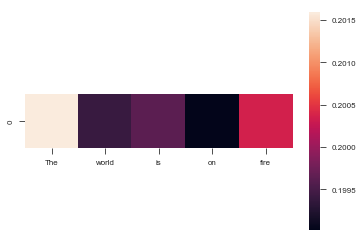

In [27]:
plot_activations(model, X[0], documents[0])